In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')


In [25]:
df = pd.read_csv('train.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


As we can see we have data for five years for 10 stores and 50 products so, if we calculate it,

(365 * 4 + 366) * 10 * 50 = 913000

Now let’s check the size we have calculated is correct or not .

In [26]:
df.shape

(913000, 4)

Let’s check which column of the dataset contains which type of data.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


As per the above information regarding the data in each column we can observe that there are no null values.

In [28]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


Feature Engineering

There are times when multiple features are provided in the same feature or we have to derive some features from the existing ones. We will also try to include some extra features in our dataset so, that we can derive some interesting insights from the data we have. Also if the features derived are meaningful then they become a deciding factor in increasing the model’s accuracy significantly.

In [29]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


Whether it is a weekend or a weekday must have some effect on the requirements to fulfill the demands.

In [30]:
from datetime import datetime
import calendar
    
def weekend_or_weekday(year,month,day):
    
    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0

df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


It would be nice to have a column which can indicate whether there was any holiday on a particular day or not.

In [31]:
from datetime import date
import holidays

def is_holiday(x):
  
  india_holidays = holidays.country_holidays('IN')

  if india_holidays.get(x):
    return 1
  else:
    return 0

df['holidays'] = df['date'].apply(is_holiday)
df.head()


,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


Now, let’s add some cyclical features.

In [33]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()


,date,store,item,sales,year,month,day,weekend,holidays,weekday,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,1,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,2,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,3,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,4,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,5,0.5,0.866025


Let’s have a column whose value indicates which day of the week it is.


In [32]:
from datetime import datetime

def which_day(year, month, day): 
    
    d = datetime(year,month,day) 
    return d.weekday() 

df['weekday'] = df.apply(lambda x: which_day(x['year'], 
                                                    x['month'], 
                                                    x['day']), 
                                axis=1) 
df.head()

# This code is modified by Susobhan Akhuli


,date,store,item,sales,year,month,day,weekend,holidays,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,1
1,2013-01-02,1,1,11,2013,1,2,0,0,2
2,2013-01-03,1,1,14,2013,1,3,0,0,3
3,2013-01-04,1,1,13,2013,1,4,0,0,4
4,2013-01-05,1,1,10,2013,1,5,1,0,5


Now let’s remove the columns which are not useful for us.

In [34]:
df.drop('date', axis=1, inplace=True)

There may be some other relevant features as well which can be added to this dataset but let’s try to build a build with these ones and try to extract some insights as well.

Exploratory Data Analysis

EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. 

We have added some features to our dataset using some assumptions. Now let’s check what are the relations between different features with the target feature.

In [35]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

From here we can conclude that there are 10 unique stores and they sell 50 different products.

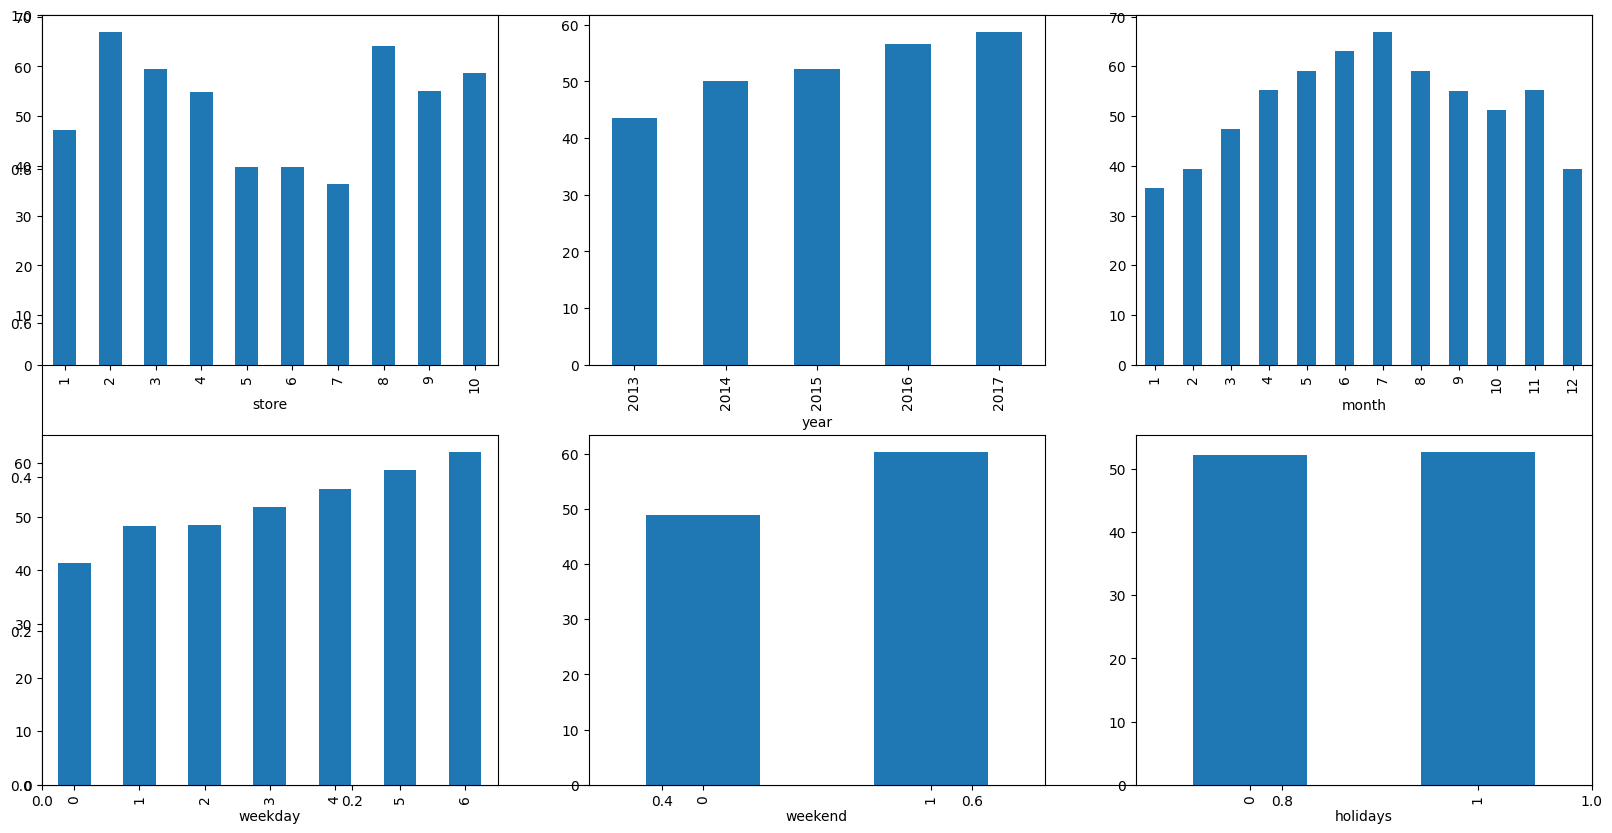

In [36]:
df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0 )
features = ['store', 'year' , 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()    

Now let’s check the variation of stock as the month closes to the end.

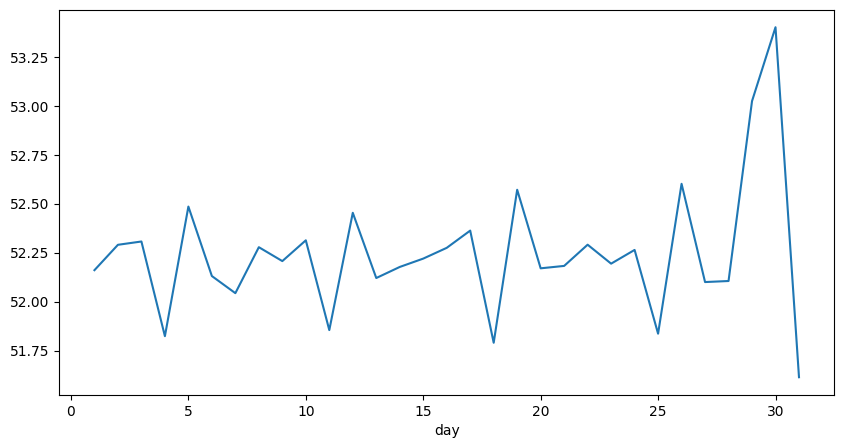

In [37]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

Let’s draw the simple moving average for 30 days period.

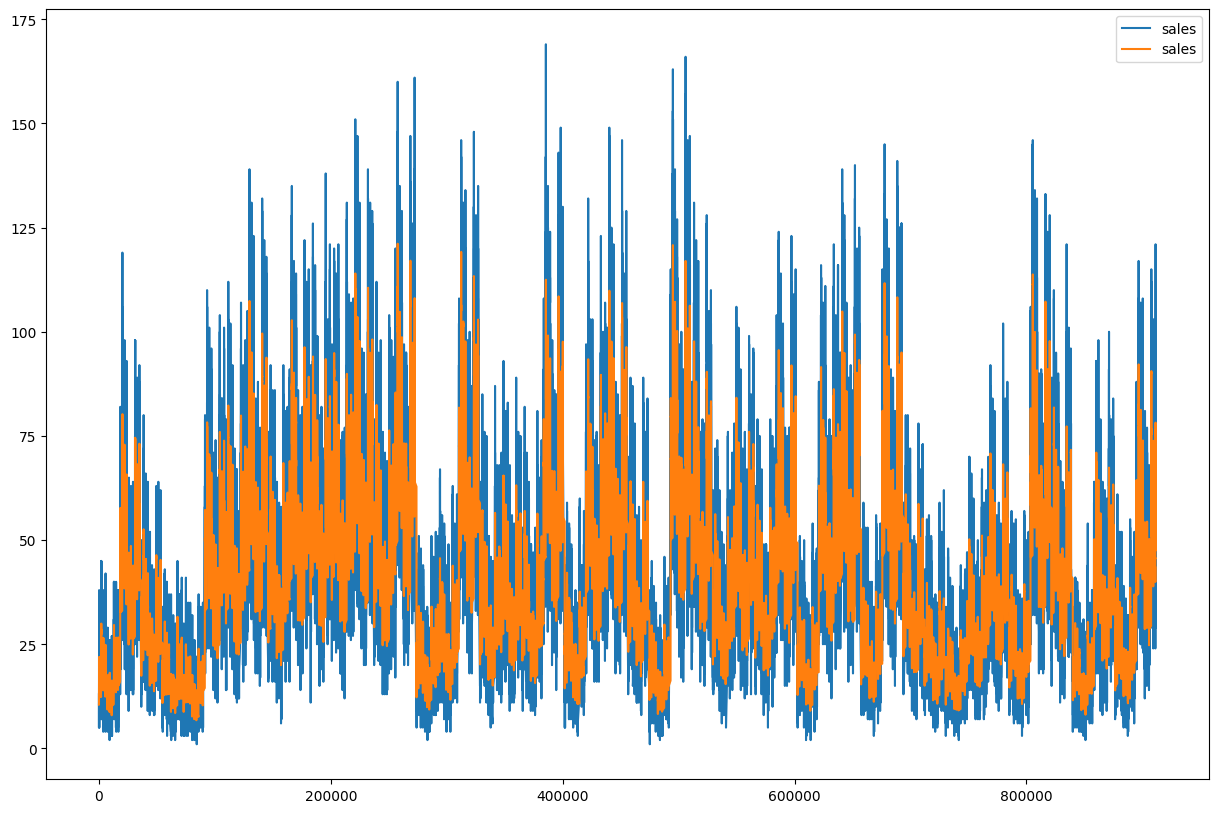

In [39]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average 
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()


As the data in the sales column is continuous let’s check the distribution of it and check whether there are some outliers in this column or not.

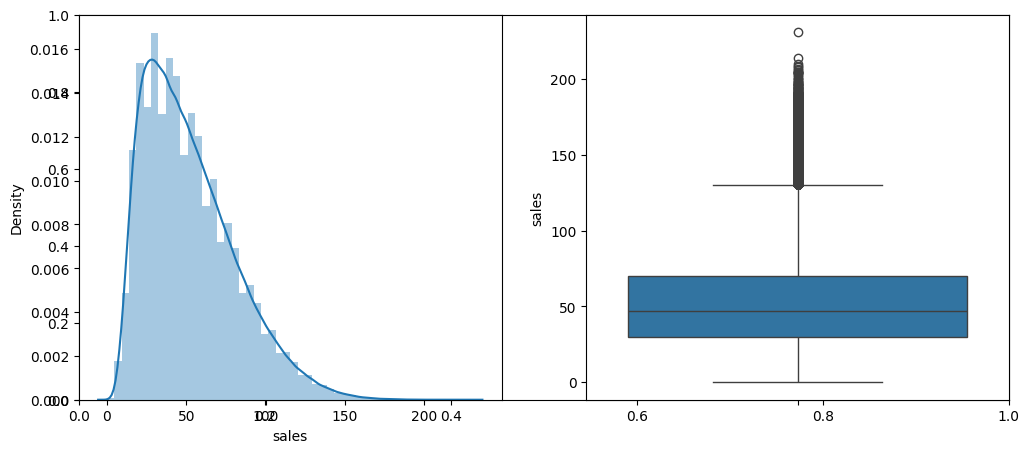

In [43]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()





Highly correlated features do

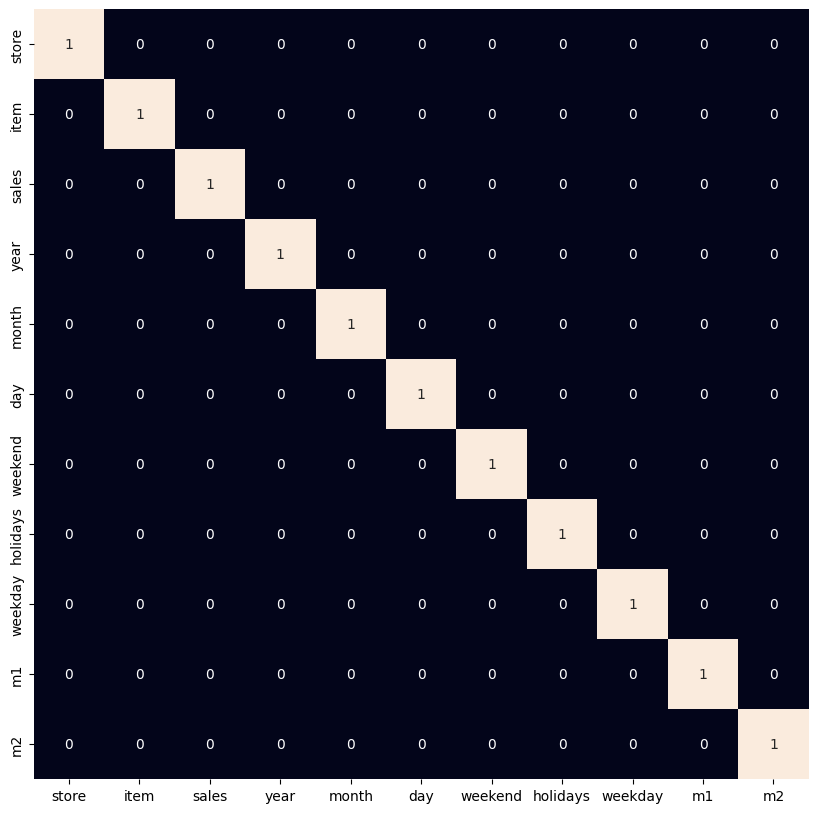

In [44]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() >0.8,
           annot=True,
           cbar=False)

plt.show()

As we observed earlier let’s remove the outliers which are present in the data.

In [45]:
df = df[df['sales']< 140 ]

Model Training

Now we will separate the features and target variables and split them into training and the testing data by using which we will select the model which is performing best on the validation data.

In [46]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values

X_train, X_val, Y_train, Y_val = train_test_split(features,target,test_size=0.05, random_state=22)
X_train.shape,X_val.shape

((861170, 9), (45325, 9))

Normalizing the data before feeding it into machine learning models helps us to achieve stable and fast training.

In [47]:
# NOrmalizing the features for stable and fast training 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

We have split our data into training and validation data also the normalization of the data has been done. Now let’s train some state-of-the-art machine learning models and select the best out of them using the validation dataset.

In [48]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
    models[i].fit(X_train,Y_train)
    
    print(f'{models[i]} : ')
    
    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))
    
    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  20.902989838083602
Validation Error :  20.97163963254153

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  6.902142131234314
Validation Error :  6.9201690247120675

Lasso() : 
Training Error :  21.015032479557025
Validation Error :  21.07151